### Import data

In [12]:
include("DDEmodel.jl")
include("plot.jl")

# import data from the path
# pop: population data
# g1, g2: g1 and g2 data
# initial: initial number of cells in g1 and in g2 at time 0
pop, g2, g1, g1_0, g2_0 = get_data("..//data//lap.csv", "..//data//lap_pop.csv");

# This is to load the estimated parameters to be used as "initial guess"
param_lap_dde = CSV.read(".//figures//Lapatinib//dde//params_lap_DDE.csv")

# initial guesses for the parameters
lap = convert(Matrix, param_lap_dde[1:7,2:end]); 

7×8 Array{Float64,2}:
 0.04728    0.03849   0.03791   0.02698   …   0.0207463   0.00959   0.0069  
 0.02655    0.02973   0.03054   0.026502      0.03743     0.02566   0.02488 
 0.45       0.62571   0.53348  20.2428       21.4483     20.9196   33.7132  
 2.0       15.1207   15.9698   21.3481       20.7143     18.9652   20.5472  
 3.1434     9.84743  11.4502   10.2881        8.15781     8.06589   5.2193  
 0.00281    0.00174   0.00064   0.0001    …   0.00246     0.00227   0.003886
 0.000387   0.00025   0.001     0.0001        0.003692    0.01039   0.0101  

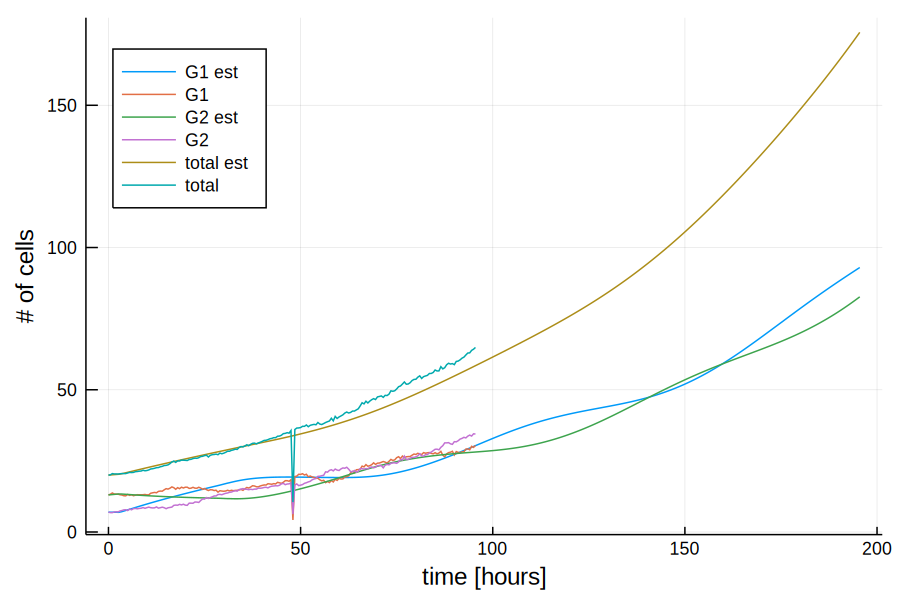

In [13]:
# i is the number of the column we are using from the data (# of trial)
i = 3

# initial guess
p  = lap[:, i]

# setting lowest delay for tau1 to be half an hour and for tau2 to be 3 hours.
low = [0.015, 0.003, 0.5, 3.0, 7.0, 0.0001, 0.0001]
upp = [0.075, 0.075, 30.0, 30.0, 100.0, 0.05, 0.05]

# Estimating the parameters for trial i
params = optimIt(p, low, upp, i, g1, g2)

# Plotting the long-term prediction along with the data 
plotIt(params, g1, g2, g1_0, g2_0, pop, i)

### To plot parameters against drug concentrations

In [ ]:
using Plots, CSV, Optim, LsqFit;

# Reading the file containing params
param_lap_dde = CSV.read(".//figures//Lapatinib//dde//params_lap_DDE.csv")
param_gem_dde = CSV.read(".//figures//Gem//dde//params_gem_DDE.csv")
param_dox_dde = CSV.read(".//figures//Dox//dde//params_dox_DDE.csv")
param_taxol1_dde = CSV.read(".//figures//taxol//dde//params_taxol1_DDE.csv")
param_tax2_dde = CSV.read(".//figures//taxol2//dde//params_tax2_DDE.csv")

# Convert the DataFrame to Matrix for plotting
lap = convert(Matrix, param_lap_dde[:,2:end])
gem = convert(Matrix, param_gem_dde[:,2:end])
dox = convert(Matrix, param_dox_dde[:,2:end])
tax = convert(Matrix, param_taxol1_dde[:,2:end])
tax2 = convert(Matrix, param_tax2_dde[:, 2:end])

@. dose_response(x, p) =  p[1] + ((p[2] - p[1]) / (1 + 10^((x - p[3]))))
""" The original formula:
y = bottom + [(top - bottom) / ( 1 + 10^(x - log EC50) )]
note that bottom is up, top is down! Notice how to choose EC50 based on drug concentrations
"""
function HillFit(drug, param_Dname, initial_guess)
    xdata = drug[8, :]
    ydata = drug[1, :]
    initial_p = initial_guess

    # fit data
    fit = curve_fit(dose_response, xdata, ydata, initial_p)
    par = fit.param
    print(par)
    # par = [1.01, 1.21, -0.03, -100.0]

    new_xdata = LinRange(minimum(xdata), maximum(xdata), 100)
    new_ydata = dose_response(new_xdata, par)

    plot(new_xdata, new_ydata, title = param_Dname, label = "predicted", linewidth=3)
    scatter!(xdata, ydata, label = "original ")
end

initial_guess = [0.01, 0.35, 40, 0.05]
p_d = "Alpha Lapatinib"
# HillFit(gem, p_d, initial_guess)
HillFit(lap, p_d, initial_guess)

In [ ]:
@. dose_response(x, p) =  p[1] + ((p[2] - p[1]) / (1 + 10^((x - p[3]) * p[4])))
x = LinRange(0.0, 500, 100)
init = [0.01, 0.05, 40, 0.05]
y = dose_response(x, init)
plot(x, y)
scatter!(lap[8, :], lap[1, :], label = "original")

In [ ]:
plot_param_conc(lap, gem, dox, tax2, 2 , "beta")
# savefig()